<a href="https://colab.research.google.com/github/yokahealthcare/Anasa-GAN/blob/master/%5BMain%20v2%5D%20%5BAE%5D%20%5BRNN%5D%20Breathing_Wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AE - AutoEncoder

## Project Strucuture

### PART 1 : Data Preprocessing


1.   Filter the zeros values (except if in the first column)
2.   Separate the data(q) according to labels
3.   Seperate q into data(X) and label(Y)
4.   Normalize the data
> X normalized using MinMaxScaler between 0 and 1
>
> Y normalized using one-hot encoding

### PART 2 : Neural Network
1.   NN Structure
2.   Optimizer : Adam(learning_rate=0.0001)
3.   Loss      : MAE (Mean Average Error)

### PART 3 : Training
1.   Training
2.   Smoothing using Savitzky-Golay filter


# PART 1 : Data Preprocessing

In [1]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

### Download the dataset

In [3]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  print('Downloding the data through internet...')
  df = pd.read_csv("https://raw.githubusercontent.com/yokahealthcare/Anasa-GAN/master/dataset/breathing_waveform_data.csv").iloc[:, :-1] # get rid of last column ("notes")
else:
  print('Not running on CoLab')
  print('Use the dataset from folder')
  df = pd.read_csv("dataset/breathing_waveform_data.csv").iloc[:, :-1] # get rid of last column ("notes")


Running on CoLab
Downloding the data through internet...


### Filter the zeros values
> This will filtered the zeros value from all column (except first column)
>
> CAUSE : I think is natural for the first column to be 0.0 (because the time(X) still on 0 second)

In [4]:
zeros_val = df[df.iloc[:, 1:].eq(0).any(axis=1)]

### Drop the table that has value zeros on it

In [5]:
df = df[~df.isin(zeros_val)].dropna()

In [6]:
df['labels'].value_counts()

normal        19060
quick          2667
hold           2133
deep           1066
deep_quick      800
Name: labels, dtype: int64

### Separate the data according to their labels

In [7]:
normal_df = df[df['labels'] == "normal"]
quick_df = df[df['labels'] == "quick"]
hold_df = df[df['labels'] == "hold"]
deep_df = df[df['labels'] == "deep"]
deep_quick_df = df[df['labels'] == "deep_quick"]

### Normalize the data

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def preprocessor(X, x_type="MinMaxScaler"):
  std_scaler = StandardScaler().fit(X)
  min_max_scaler = MinMaxScaler().fit(X)

  if x_type == "StandardScaler":
    return std_scaler.transform(X)
  elif x_type == "MinMaxScaler":
    return min_max_scaler.transform(X)

# PART 2 : Setup The Neural Network + Training

### Importing Neural Network Libraries

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Activation

from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

### Neural Network : Deep Fully Connected

In [10]:
def AE(dropout_rate=0.2, init_mode='glorot_uniform'):
    model = Sequential()
    # Encoder layers
    model.add(Dense(64, kernel_initializer=init_mode, input_shape=(85,)))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))
    model.add(Dense(32))
    model.add(LeakyReLU())
    model.add(Dense(16))
    model.add(LeakyReLU())

    # Decoder layers
    model.add(Dense(16, input_shape=(8,)))
    model.add(LeakyReLU())
    model.add(Dense(32))
    model.add(LeakyReLU())
    model.add(Dense(64))
    model.add(LeakyReLU())
    model.add(Dense(85))
    model.add(Activation(tf.keras.activations.sigmoid))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

    return model

### GridSearchCV

In [11]:
import multiprocessing
cpu_count = multiprocessing.cpu_count()
print(f"Number of CPU cores: {cpu_count}")

Number of CPU cores: 2


In [12]:
def fit_and_print(X, params, cv=2, n_jobs=cpu_count-2):
  model_kr = KerasRegressor(model=AE)

  # Create the grid search object
  grid_search = GridSearchCV(estimator=model_kr, param_grid=params, cv=2, verbose=1, refit=True, n_jobs=n_jobs)

  # Fit the grid search object to your data
  grid_search.fit(X, X)  # Assuming X_train is your training data

  # Print the best hyperparameters and the corresponding mean squared error
  print("Best Hyperparameters:", grid_search.best_params_)
  print("Best MSE:", -grid_search.best_score_)

  return grid_search

# PART 3 : Saving Model

In [13]:
import os
def save_all(dir, grid_search):
  # complement that
  dir += '\\'

  ## save the best model
  # You have add or remove the argument according to GridSearchCV HYPERPARAMATERS
  main_model = AE()
  history = main_model.fit(X, X, epochs=10, batch_size=32, verbose=0)
  main_model.save(dir+"best_model.h5")

  # plot the loss on training the best model
  plt.plot(history.history["loss"], label="Training Loss")
  plt.legend()
  print("Mean Average Error : {}%".format(np.mean(history.history["loss"])*100))

  ## save the result of gridsearchcv
  res = pd.DataFrame(grid_search.cv_results_)
  res.to_csv(dir+"grid_search_result.csv")

  ## Create the encoder model using the trained weights
  encoder_output = main_model.layers[8].output
  encoder_model = tf.keras.Model(inputs=main_model.input, outputs=encoder_output)
  encoder_model.save(dir+"best_model_encoder.h5")

  ## Create the decoder model using the trained weights
  decoder_input = main_model.layers[9].input
  decoder_model = tf.keras.Model(inputs=decoder_input, outputs=main_model.output)
  decoder_model.save(dir+"best_model_decoder.h5")

  print("All Successfully Saved!")
  return res, main_model, encoder_model, decoder_model


# PART 4 : Testing the Model

### Define a function to smoothing the wave curve

In [14]:
# smoothing the wave of decoded_data
from scipy.signal import savgol_filter

def smooth_wave(wave):
  # Define the parameters for the Savitzky-Golay filter
  window_length = 10  # The length of the window (odd number)
  polyorder = 2  # The order of the polynomial fit

  return savgol_filter(wave, window_length, polyorder)

### Define a function to plot the result

In [15]:
def plot_graph(tran_X, reconstructed, loss, num_samples=20):
  row = int(num_samples / 5)

  # Create figure and axis objects
  fig, ax = plt.subplots(row, 5, figsize=(20,row*3))

  idx=0
  for y in range(row):
    for x in range(5):
      # Plot each time series
      ax[y, x].plot(tran_X[idx], 'b')
      ax[y, x].plot(reconstructed[idx], 'g')
      ax[y, x].fill_between(np.arange(X.shape[1]), reconstructed[idx], tran_X[idx], color='lightcoral')
      ax[y, x].set_title("Data {}; err : {:.2f}%".format(idx, loss[idx]*100))
      #ax[y, x].legend()

      idx += 1

  # legend
  plt.legend(labels=["Input", "Reconstruction", "Error"], loc='center left', bbox_to_anchor=(1, 0.5))

  # Customize the overall layout
  plt.tight_layout()

  # Show
  plt.show()

### Testing the model

In [16]:
def test_model(tran_X, encoder_model, decoder_model):
  # encode & decode the wave
  print("Encoding...")
  encoded = encoder_model.predict(tran_X)
  print("Decoding...")
  decoded = decoder_model.predict(encoded)

  # Apply the Savitzky-Golay filter (smoothing the wave)
  decoded_smoothed = smooth_wave(decoded)

  # Calculate the Mean Average Error (MAE)
  loss_actual = tf.keras.losses.mae(decoded, tran_X)
  loss_smoothed = tf.keras.losses.mae(decoded_smoothed, tran_X)
  print("[actual] Mean Average Error : {}%".format(np.mean(loss_actual * 100)))
  print("[smoothed] Mean Average Error : {}%".format(np.mean(loss_smoothed * 100)))

  # plot the reconstructed data vs actual data
  plot_graph(tran_X, decoded_smoothed, loss_smoothed, num_samples=25)


# PART 5 : ALL IN ONE BUTTON

In [17]:
def run_all(X):
  # Preprocessed the data
  tran_X = preprocessor(X, x_type="MinMaxScaler")

  # Define the hyperparameters and their values to search
  param_grid = {
      'epochs': [10],
      'batch_size': [32],
      'model__dropout_rate': [0.2],
      'model__init_mode': ['glorot_uniform']
  }

  grid_search = fit_and_print(tran_X, params=param_grid, cv=2, n_jobs=-1)

  # Saving the model
  dir = os.getcwd()
  gs_csv, main_model, encoder_model, decoder_model = save_all(dir, grid_search)

  # Testing the model
  test_model(tran_X, encoder_model, decoder_model)

  return gs_csv, main_model, encoder_model, decoder_model

### Seperate the data (X)
> we don't need Y (label) because we already seperate the dataset according to their label each one
>
> **"normal"** (19060), **"quick"** (2667), **"hold"** (2133), **"deep"** (1066), **"deep_quick"** (800)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/10
84/84 [==============================] - 3s 10ms/step - loss: 0.1155
Epoch 2/10
84/84 [==============================] - 1s 8ms/step - loss: 0.0801
Epoch 3/10
84/84 [==============================] - 1s 10ms/step - loss: 0.0661
Epoch 4/10
84/84 [==============================] - 1s 10ms/step - loss: 0.0587
Epoch 5/10
84/84 [==============================] - 1s 7ms/step - loss: 0.0553
Epoch 6/10
84/84 [==============================] - 1s 7ms/step - loss: 0.0544
Epoch 7/10
84/84 [==============================] - 0s 6ms/step - loss: 0.0542
Epoch 8/10
84/84 [==============================] - 1s 8ms/step - loss: 0.0533
Epoch 9/10
84/84 [==============================] - 1s 7ms/step - loss: 0.0525
Epoch 10/10
84/84 [==============================] - 0s 6ms/step - loss: 0.0521
Best Hyperparameters: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.2, 'model__init_mode': 'glorot_uniform'}
Best MSE: -0.7835951833756

Mean Average Error : 26.574855595827103%
All Successfully Saved!
Encoding...
84/84 [==============================] - 1s 7ms/step
Decoding...
84/84 [==============================] - 0s 2ms/step
[actual] Mean Average Error : 23.10936437608423%
[smoothed] Mean Average Error : 22.99205001881542%


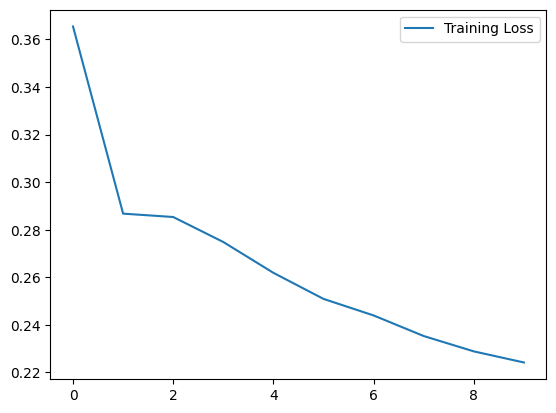

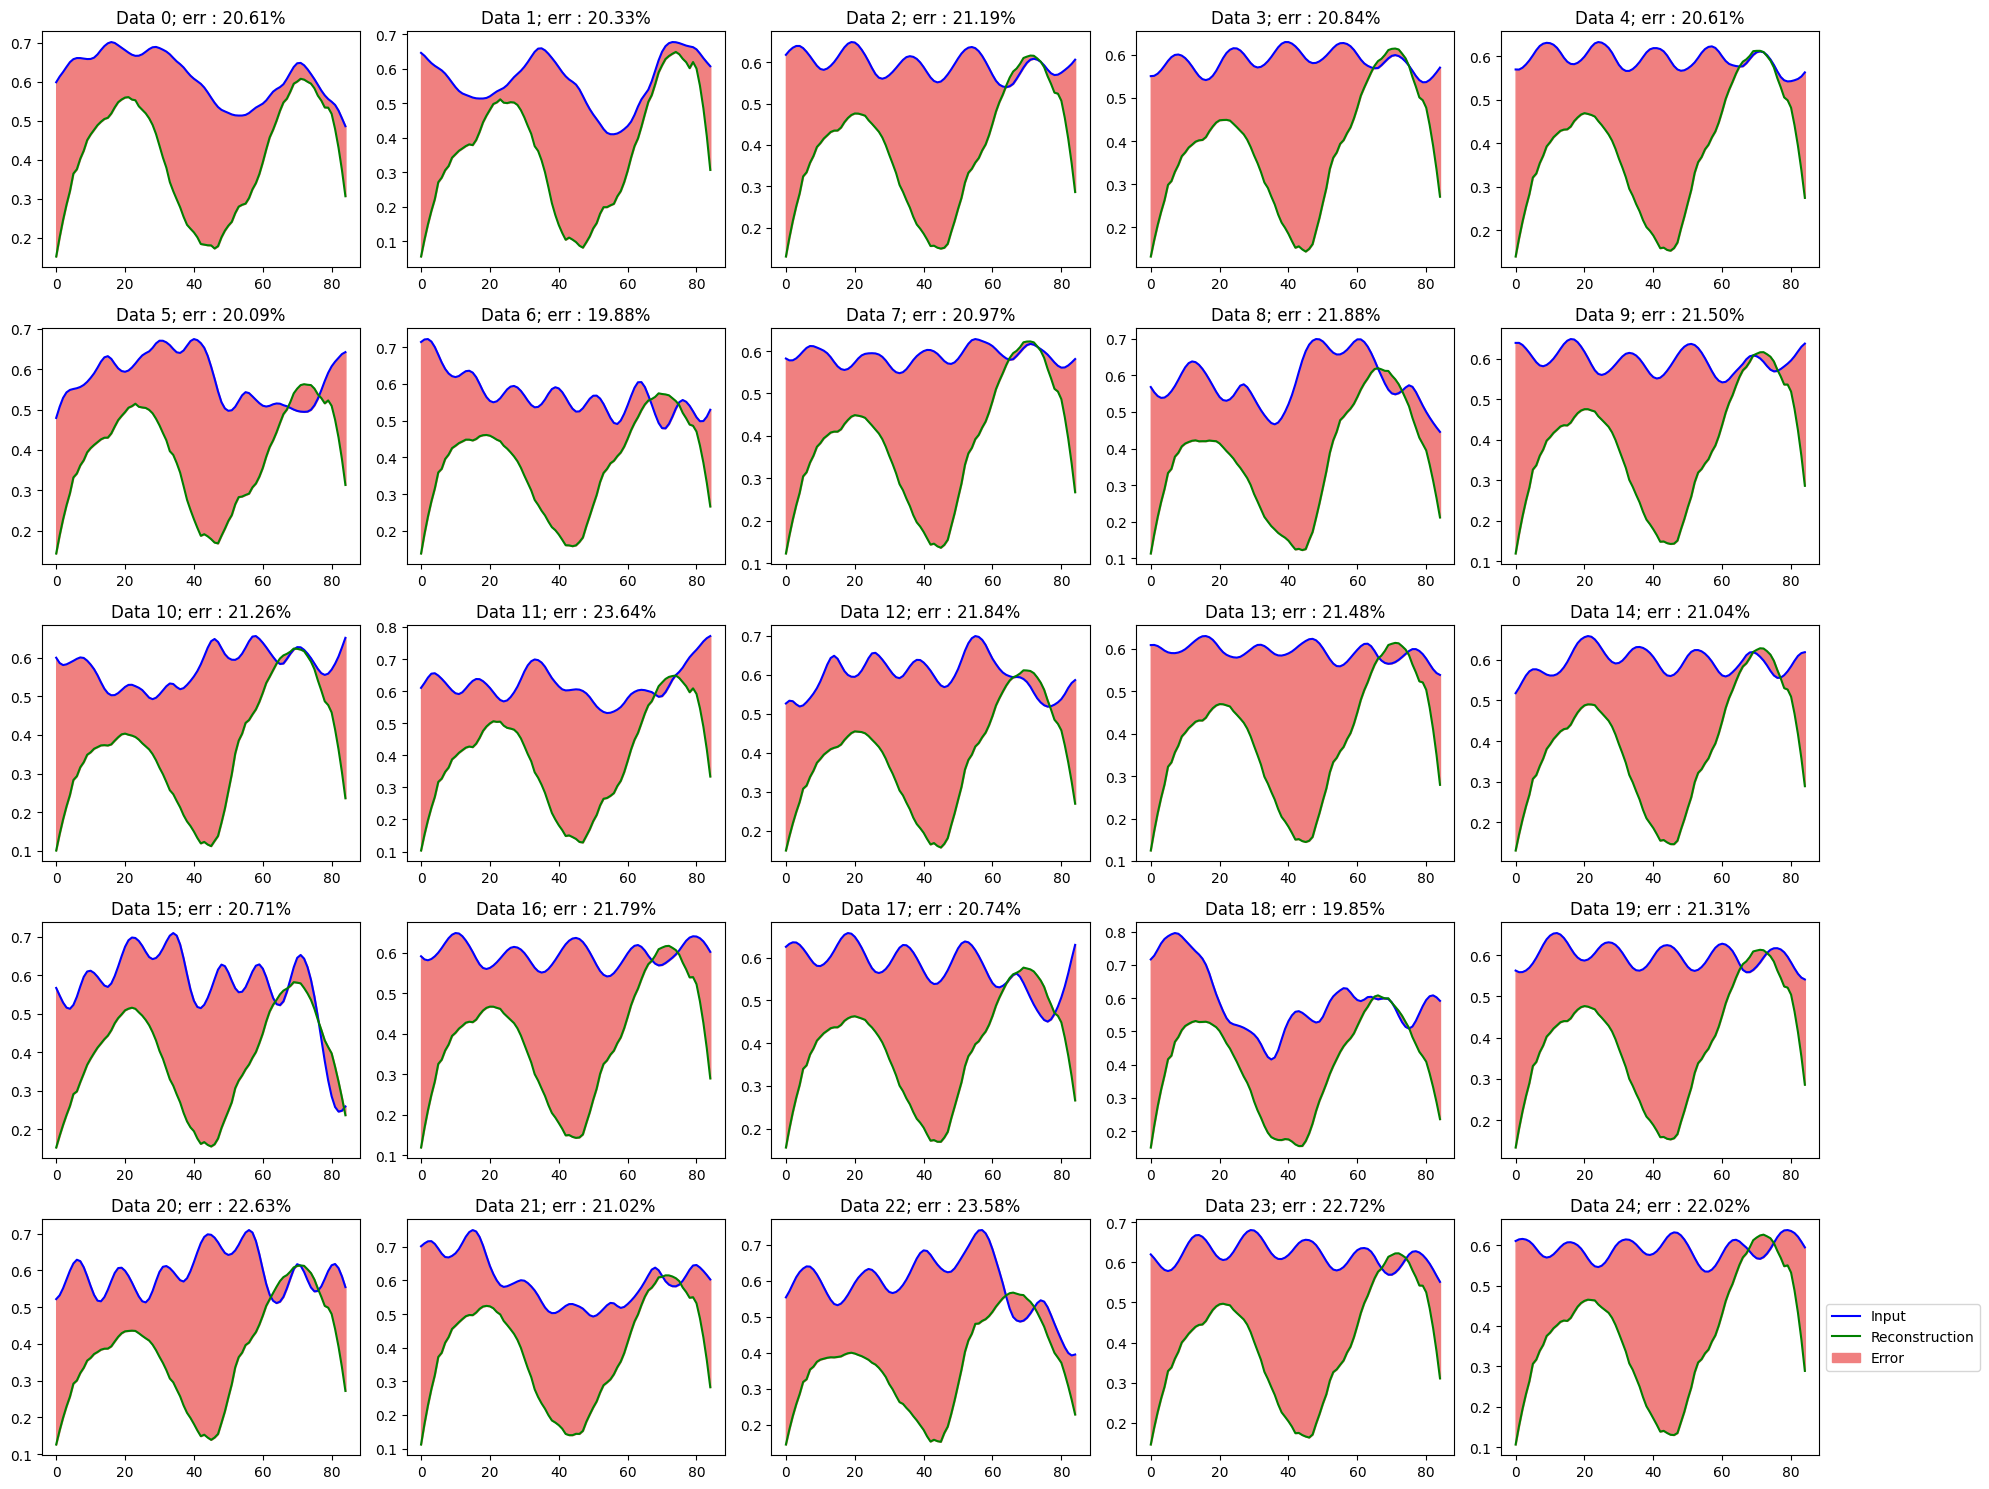

In [18]:
X = quick_df.iloc[:, :-1]
gs_csv, main_model, encoder_model, decoder_model = run_all(X)

# PART 6 : Generating New Data

### Define a function to plotting the generated data result

In [19]:
def plot_graph_generated(generated_data, num_samples=10):
  # Create figure and axis objects
  row = int(num_samples / 5)

  fig, ax = plt.subplots(row, 5, figsize=(20,row*3))

  idx=0
  for y in range(row):
    for x in range(5):
      # Plot each time series
      ax[y, x].plot(generated_data[idx], 'b')
      ax[y, x].set_title("Data {}".format(idx))

      idx += 1

  # legend
  plt.legend(labels=["Generated"], loc='center left', bbox_to_anchor=(1, 0.5))

  # title
  plt.suptitle("Generated Data with Smoothing")

  # Customize the overall layout
  plt.tight_layout()

  # Show
  plt.show()

### Setting up parameters

In [20]:
# Set the number of data points to generate
generated_samples = 10
# Randomly sample latent vectors from a predefined range
noise_vectors = np.random.rand(*(generated_samples, 85))
# Generate new data by decoding the latent vectors
generated_data = main_model.predict(noise_vectors)

1/1 [==============================] - 0s 108ms/step


### Plot the generated data before & after smoothing process

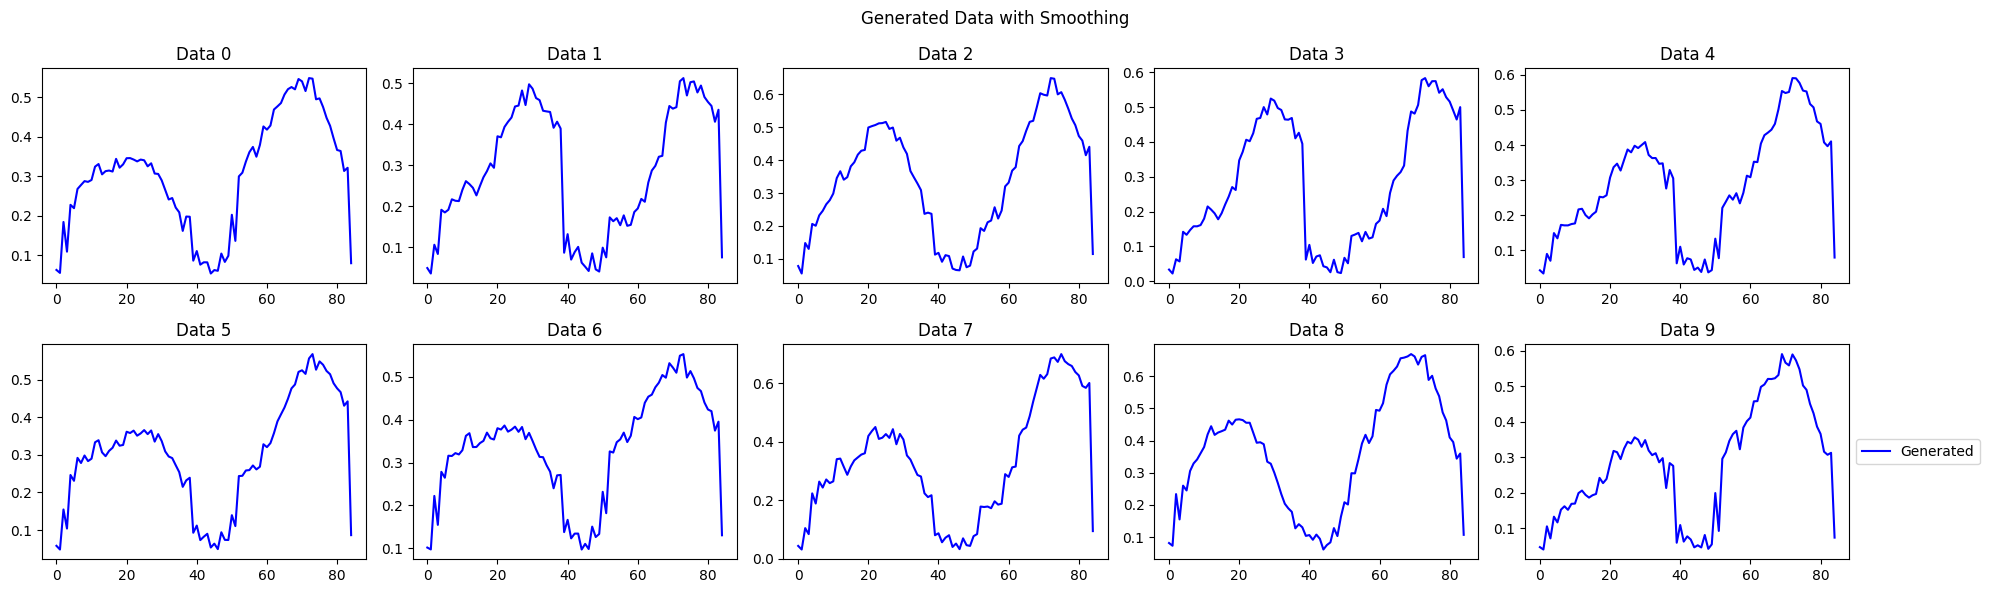

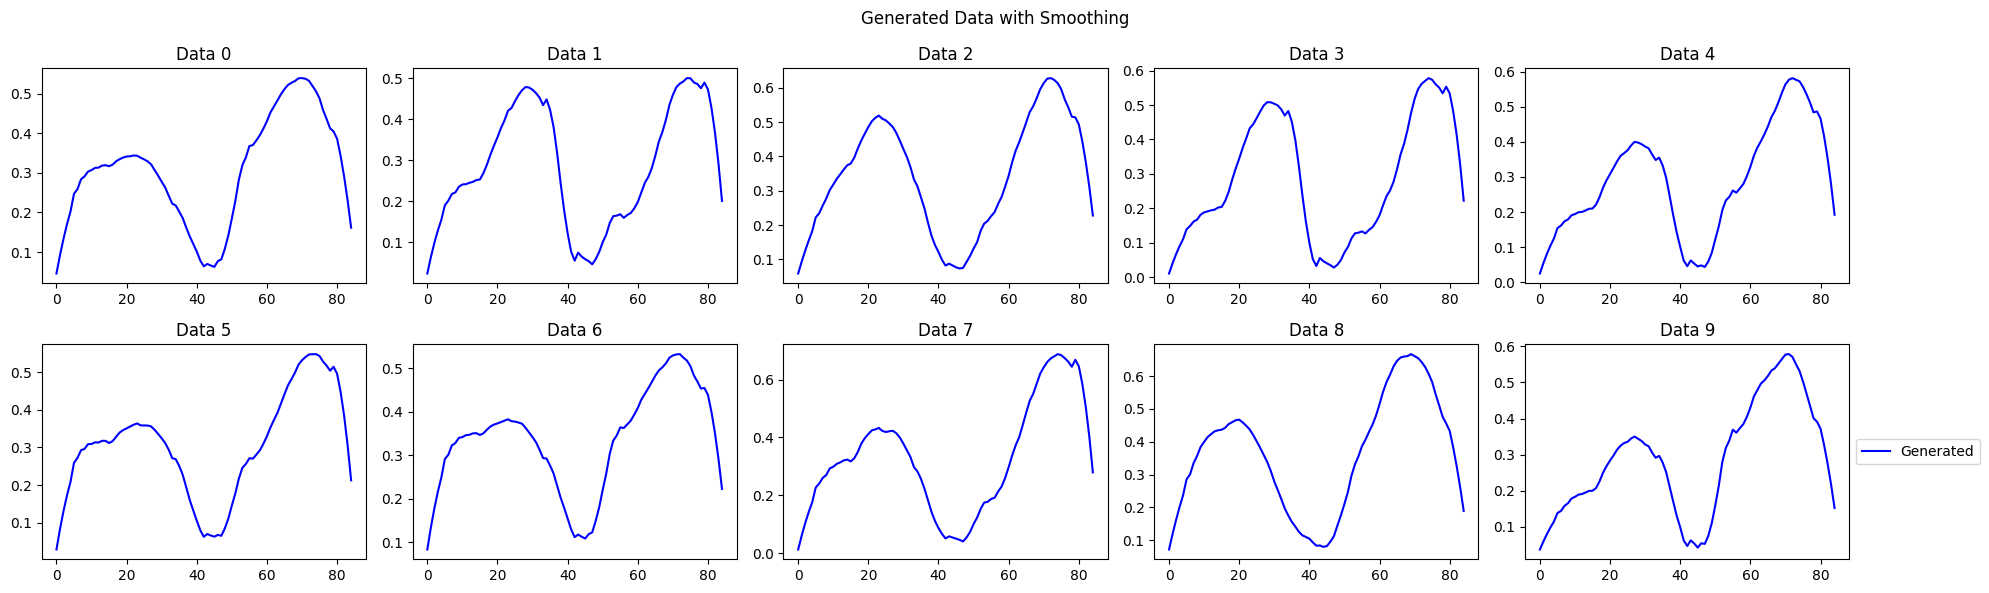

In [21]:
# Plot the graph before smoothing process
plot_graph_generated(generated_data, num_samples=generated_samples)
# Apply the Savitzky-Golay filter
generated_data_smoothed = smooth_wave(generated_data)
# Plot the graph after smoothing process
plot_graph_generated(generated_data_smoothed, num_samples=generated_samples)